# Import Dataset & Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling

# Hide warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import os
PATH = os.path.join('ml-latest-small','')

In [5]:
#Main Dataset
movies = pd.read_csv(PATH + 'movies.csv', low_memory=False)

# Dataset for content based recommender
tmdb = pd.read_csv(PATH + 'tmdb.csv', delimiter=';', low_memory=False)
casts = pd.read_csv(PATH + 'tmdb_cast.csv', delimiter=';', low_memory=False)
links = pd.read_csv(PATH + 'links.csv', low_memory=False)
tags = pd.read_csv(PATH + 'tags.csv', low_memory=False)

# Dataset for collaborative filtering
ratings = pd.read_csv(PATH + 'ratings.csv', low_memory=False)

# Data Manipulation

In [6]:
# Keep certain columns in casts Dataframe
casts = casts[[
    'id', 'actor1_name', 'actor2_name', 'actor3_name', 'director_name'
]]

# Keep certain columns in tmdb Dataframe
tmdb.head(2)
tmdb = tmdb[['id', 'overview', 'production_companies', 'production_countries']]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,69.0,suomi,Released,NaN,Ariel,7.1,40,2,1,2
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,76.0,English,Released,NaN,Shadows in Paradise,7.0,32,1,1,3


In [7]:
# Keep certain columns in tags Dataframe
tags = tags[['movieId', 'tag']].drop_duplicates()

# Aggregate tags with same movieId into a list, then convert list to string
tags = tags.groupby(by='movieId')['tag'].apply(list).reset_index(name='tag')
tags['tag'] = [" ".join(map(str, l)) for l in tags['tag']]

In [8]:
# Merge casts and tmdb for Metadata
tmdb_full = pd.merge(tmdb, casts, how='left', on='id')

# Merge tmdb_full and movies using links Dataframe for keys
merge1 = pd.merge(movies,
                  links[['movieId', 'tmdbId']],
                  how='left',
                  on='movieId')

df = pd.merge(merge1, tmdb_full, how='left', left_on='tmdbId', right_on='id')

# Merge tags to the full df
df = pd.merge(df, tags, how='left', on='movieId')

# Extract year from title
df['year'] = df['title'].str[-5:-1]

In [9]:
df.head(2)

,movieId,title,genres,tmdbId,id,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,862.0,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,United States of America,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,pixar fun,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844.0,8844.0,When siblings Judy and Peter discover an encha...,TriStar Pictures,United States of America,Robin Williams,Jonathan Hyde,Kirsten Dunst,Joe Johnston,fantasy magic board game Robin Williams game,1995


# Data Exploratory Analysis

## Df Dataframe

In [10]:
df.shape
df.info()

(9742, 14)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieId               9742 non-null   int64  
 1   title                 9742 non-null   object 
 2   genres                9742 non-null   object 
 3   tmdbId                9734 non-null   float64
 4   id                    9637 non-null   float64
 5   overview              9613 non-null   object 
 6   production_companies  9637 non-null   object 
 7   production_countries  9637 non-null   object 
 8   actor1_name           9637 non-null   object 
 9   actor2_name           9637 non-null   object 
 10  actor3_name           9637 non-null   object 
 11  director_name         9637 non-null   object 
 12  tag                   1572 non-null   object 
 13  year                  9742 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.1+ MB


In [11]:
# Drop unused columns
df.drop(columns=['tmdbId', 'id'], inplace=True)

# Find how many NaN value and fill them with blank
df.isna().sum()
df = df.fillna('')
df.isna().sum()

movieId                    0
title                      0
genres                     0
overview                 129
production_companies     105
production_countries     105
actor1_name              105
actor2_name              105
actor3_name              105
director_name            105
tag                     8170
year                       0
dtype: int64

movieId                 0
title                   0
genres                  0
overview                0
production_companies    0
production_countries    0
actor1_name             0
actor2_name             0
actor3_name             0
director_name           0
tag                     0
year                    0
dtype: int64

In [12]:
# Remove 'none' instance with empty string in selected columns
for i in [
        'production_companies', 'production_countries', 'actor1_name',
        'actor2_name', 'actor3_name', 'director_name', 'tag'
]:
    df.loc[df[i].astype(str) == 'none', i] = ''

In [13]:
df.head(2)

,movieId,title,genres,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,United States of America,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,pixar fun,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,TriStar Pictures,United States of America,Robin Williams,Jonathan Hyde,Kirsten Dunst,Joe Johnston,fantasy magic board game Robin Williams game,1995


<AxesSubplot:xlabel='count', ylabel='production_countries'>

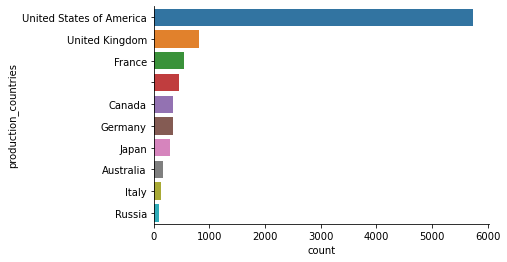

In [14]:
sns.countplot(y=df['production_countries'],
              order=df['production_countries'].value_counts().iloc[:10].index)
sns.despine(top=True, right=True)

<AxesSubplot:xlabel='count', ylabel='production_companies'>

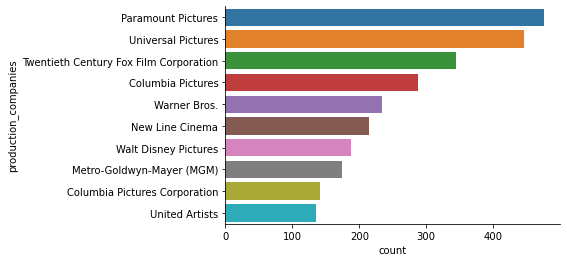

In [15]:
sns.countplot(y=df['production_companies'],
              order=df['production_companies'].value_counts().iloc[1:11].index)
sns.despine(top=True, right=True)

<AxesSubplot:xlabel='count', ylabel='director_name'>

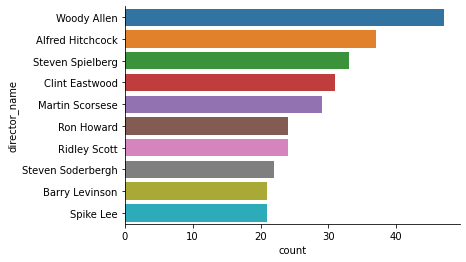

In [16]:
sns.countplot(y=df['director_name'],
              order=df['director_name'].value_counts().iloc[1:11].index)
sns.despine(top=True, right=True)

<AxesSubplot:xlabel='count', ylabel='actor1_name'>

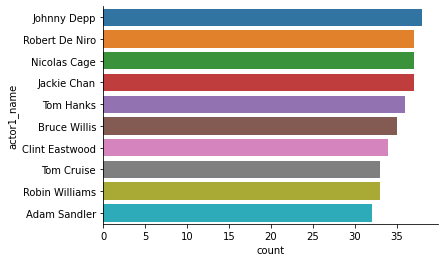

In [17]:
sns.countplot(y=df['actor1_name'],
              order=df['actor1_name'].value_counts().iloc[1:11].index)
sns.despine(top=True, right=True)

## Ratings Dataframe

In [18]:
ratings.shape
ratings.info()

(100836, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [19]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [20]:
ratings.tail(5)

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [21]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<AxesSubplot:xlabel='rating', ylabel='count'>

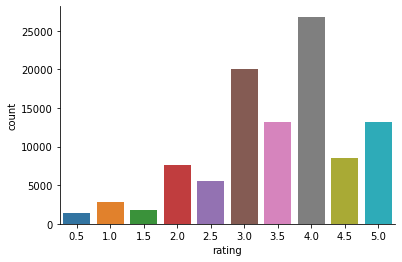

In [22]:
sns.countplot(ratings['rating'])
sns.despine(top=True, right=True)

In [23]:
genres = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

genres_rating_list = []

for i in range(len(genres)):
    fil = genres[i] + '_filter'
    mov = genres[i] + '_movies'
    rat = genres[i] + '_ratings'
    rat_mean = rat + '_mean'
    fil = movies['genres'].str.contains(genres[i])
    mov = movies[fil]
    rat = mov.merge(ratings, on='movieId', how='inner')
    rat_mean = round(rat['rating'].mean(), 2)
    genres_rating_list.append(rat_mean)

genres_rating = {'Genre': genres, 'Genres Mean Rating': genres_rating_list}
genres_rating = pd.DataFrame(genres_rating)

<AxesSubplot:xlabel='Genre', ylabel='Genres Mean Rating'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Animation'),
  Text(3, 0, 'Children'),
  Text(4, 0, 'Comedy'),
  Text(5, 0, 'Crime'),
  Text(6, 0, 'Documentary'),
  Text(7, 0, 'Drama'),
  Text(8, 0, 'Fantasy'),
  Text(9, 0, 'Film-Noir'),
  Text(10, 0, 'Horror'),
  Text(11, 0, 'Musical'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Romance'),
  Text(14, 0, 'Sci-Fi'),
  Text(15, 0, 'Thriller'),
  Text(16, 0, 'War'),
  Text(17, 0, 'Western')])

(3.0, 4.0)

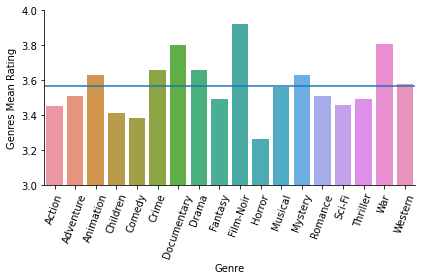

In [24]:
sns.barplot(x='Genre', y='Genres Mean Rating', data=genres_rating)
plt.xticks(rotation=70)
plt.ylim([3, 4])
plt.tight_layout()
plt.axhline(genres_rating['Genres Mean Rating'].mean())
sns.despine(top=True, right=True)
plt.show()

In [25]:
genres = movies.genres.str.get_dummies()
genres = genres.drop(columns=['(no genres listed)', 'IMAX'])
genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
total = genres.sum()

In [27]:
total.sort_values(ascending=False)

Drama          4361
Comedy         3756
Thriller       1894
Action         1828
Romance        1596
Adventure      1263
Crime          1199
Sci-Fi          980
Horror          978
Fantasy         779
Children        664
Animation       611
Mystery         573
Documentary     440
War             382
Musical         334
Western         167
Film-Noir        87
dtype: int64

<AxesSubplot:>

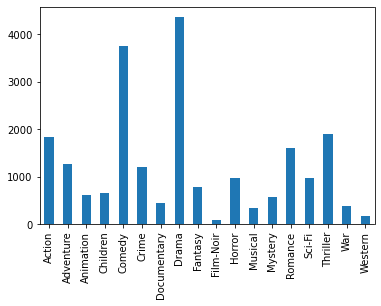

In [28]:
total.plot(kind='bar')

In [29]:
genres_rating['Genres Mean Rating'].mean()

3.5672222222222225

# Content-Based Recommender using Cosine Similarity

## Recommender using Synopsis

In [30]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9742, 30537)

In [31]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
cosine_sim.shape

(9742, 9742)

In [33]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
indices[:10]

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
Heat (1995)                           5
Sabrina (1995)                        6
Tom and Huck (1995)                   7
Sudden Death (1995)                   8
GoldenEye (1995)                      9
dtype: int64

In [34]:
def get_recommendations(title, cosine_sim=cosine_sim):
    #Get index of the movie with the input title
    idx = indices[title]

    #Get the cosine similarity pairwise score of the movie vs others
    scores = cosine_sim[idx]  #this is an array

    #Create a list with index for the pairwise score
    sim_scores = list(enumerate(
        scores))  # enumerate creates the index, list creates the list

    #Sort the movies based on similarity scores
    sim_scores = sorted(
        sim_scores,
        key=lambda list: list[1],  #sort by score (2nd position of the list)
        reverse=True)  #sort from highest to lowest

    #Get the scores of the top 10 most similar movies
    sim_scores = sim_scores[1:11]  #this is a list

    #Get the indices of those similar movies to get their names
    movie_indices = [i[0] for i in sim_scores]  #this is an array

    #Return the names of the top 10 similar movies
    return df['title'].iloc[movie_indices]

## Improve Cosine Similarity with Credits, Genres and Keyword

In [35]:
df['genres_split'] = df['genres'].str.replace('|', " ", regex=True)

In [36]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [37]:
# Apply clean_data function to your features.
features = [
    'production_companies', 'production_countries', 'actor1_name',
    'actor2_name', 'actor3_name', 'director_name', 'tag'
]

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [38]:
df.head(2)

,movieId,title,genres,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year,genres_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",pixaranimationstudios,unitedstatesofamerica,tomhanks,timallen,donrickles,johnlasseter,pixarfun,1995,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,tristarpictures,unitedstatesofamerica,robinwilliams,jonathanhyde,kirstendunst,joejohnston,fantasymagicboardgamerobinwilliamsgame,1995,Adventure Children Fantasy


In [39]:
df['soup'] = df['overview'] + " " + df['production_countries'] + " " + df[
    'production_companies'] + " " + df['actor1_name'] + " " + df[
        'actor2_name'] + " " + df['actor3_name'] + " " + df[
            'director_name'] + " " + df['year'] + " " + df[
                'genres_split'] + " " + df['tag']

In [40]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [41]:
count_matrix.shape

(9742, 48021)

In [42]:
count_matrix.indices

array([25558, 47262,  2297, ..., 36099, 42447, 22128])

In [43]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [44]:
df.head(2)

,movieId,title,genres,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year,genres_split,soup
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",pixaranimationstudios,unitedstatesofamerica,tomhanks,timallen,donrickles,johnlasseter,pixarfun,1995,Adventure Animation Children Comedy Fantasy,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,tristarpictures,unitedstatesofamerica,robinwilliams,jonathanhyde,kirstendunst,joejohnston,fantasymagicboardgamerobinwilliamsgame,1995,Adventure Children Fantasy,When siblings Judy and Peter discover an encha...


In [45]:
get_recommendations('Toy Story (1995)', cosine_sim)

7355                Toy Story 3 (2010)
2355                Toy Story 2 (1999)
5972    40-Year-Old Virgin, The (2005)
840       Rebel Without a Cause (1955)
2392            Man on the Moon (1999)
6343     For Your Consideration (2006)
9207       Welcome to Happiness (2015)
1512                  Condorman (1981)
427                      Malice (1993)
6421               Factory Girl (2006)
Name: title, dtype: object

In [46]:
get_recommendations('Toy Story (1995)', cosine_sim2)

2355                                   Toy Story 2 (1999)
7355                                   Toy Story 3 (2010)
5972                       40-Year-Old Virgin, The (2005)
7733                                 Puss in Boots (2011)
8385                         Mr. Peabody & Sherman (2014)
9586           In the blue sea, in the white foam. (1984)
3568                                Monsters, Inc. (2001)
8715                                 Halloweentown (1998)
8219                                         Turbo (2013)
585     Wallace & Gromit: The Best of Aardman Animatio...
Name: title, dtype: object

# Collaborative Filtering with different Algos

## Cross Validation to find best Algos

In [48]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate

from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import NormalPredictor, BaselineOnly
from surprise import SVD, NMF, SlopeOne, CoClustering

In [49]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [50]:
knnb = KNNBasic()
knnwm = KNNWithMeans()
knnwz = KNNWithZScore()
normal_pred = NormalPredictor()
baseline = BaselineOnly()
nmf = NMF()
svd = SVD()
slope = SlopeOne()
cocluster = CoClustering()

In [51]:
algos = [
    'knnb', 'knnwm', 'knnwz', 'normal_pred', 'baseline', 'nmf', 'slope',
    'cocluster', 'svd'
]
rmse = {algo: {} for algo in algos}
mae = {algo: {} for algo in algos}

for algo in algos:
    c = cross_validate(eval(algo),
                       data,
                       measures=['RMSE', 'MAE'],
                       cv=10,
                       verbose=True)
    rmse[algo] = c['test_rmse']
    mae[algo] = c['test_mae']

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9361  0.9405  0.9473  0.9437  0.9266  0.9466  0.9320  0.9321  0.9558  0.942

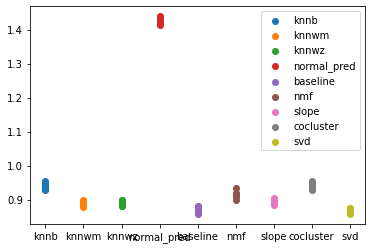

In [52]:
for key in rmse:
    plt.scatter([key] * 10, rmse[key], label=key)

plt.legend()

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

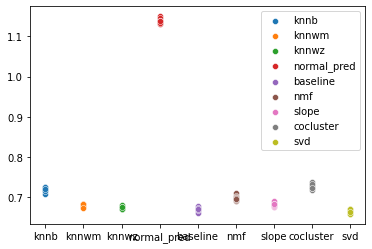

In [53]:
for key in mae:
    sns.scatterplot([key] * 10, mae[key], label=key, legend='auto')

## Train Model and Recommendation

In [54]:
from surprise.model_selection import GridSearchCV

In [55]:
param_grid = {
    'n_epochs': [5, 10, 15, 20, 25],
    'lr_all': [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01],
    'reg_all': [0.01, 0.02, 0.03, 0.04, 0.05]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8677926804395577
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.05}


In [56]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [57]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [58]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = svd.test(testset)

top_n = get_top_n(predictions, n=10)

In [67]:
def get_recommendation_collaborative(id):
    for uid, user_ratings in top_n.items():
        if uid == id:
            [
                print(df.query('movieId==' + str(i)).title.values)
                for i in [iid for (iid, _) in user_ratings]
            ]

In [68]:
get_recommendation_collaborative(50)

['Boot, Das (Boat, The) (1981)']
['Usual Suspects, The (1995)']
['This Is Spinal Tap (1984)']
['Lord of the Rings: The Fellowship of the Ring, The (2001)']
['Eternal Sunshine of the Spotless Mind (2004)']
['Yojimbo (1961)']
['Untouchables, The (1987)']
['Princess Bride, The (1987)']
['Casino (1995)']
['Harold and Maude (1971)']


In [65]:
def get_top_10(id):
    top = ratings[ratings['userId'] == id].sort_values(
        by=['rating'], ascending=False).head(10)
    top = top['movieId'].tolist()
    return df[df['movieId'].isin(top)].title

In [66]:
get_top_10(50)

706                          2001: A Space Odyssey (1968)
863                Monty Python and the Holy Grail (1975)
901                                         Brazil (1985)
903     Good, the Bad and the Ugly, The (Buono, il bru...
906                             Lawrence of Arabia (1962)
909                                 Apocalypse Now (1979)
932                                        Stalker (1979)
950                                     8 1/2 (8½) (1963)
951                                      Chinatown (1974)
4893                                       Persona (1966)
Name: title, dtype: object